In [11]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [12]:
hn = 3 #hidden state dim

class Model(nn.Module):
     
    def __init__(self, N):
        super().__init__()
        self.N = N
        self.stepLength = 2        
        self.hidden_initial = nn.Parameter(torch.empty(1, hn).normal_(mean=0, std=1)) #make inital hidden trainable
        self.hidden = self.hidden_initial.repeat((self.N, 1))  
        
        self.Whh = nn.Linear(hn, hn)
        self.Whx = nn.Linear(1, hn, bias = False)
        
        self.layer1 = nn.Linear(1 + hn, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 1)
  
    
    def forward_DNN(self, x):
        """Approximate wave function"""
        
        #concatenate hidden state to input of DNN
        if self.hidden.shape[0] == x.shape[0]:
            y = torch.cat((self.hidden, x), 1)
        else:
            y = torch.cat((self.hidden[0].repeat(x.shape[0], 1), x), 1)
            
        y = torch.relu(self.layer1(y))
        y = torch.relu(self.layer2(y))
        y = self.layer3(y)
     
        return y
    
    
    def forward_RNN(self, x):
        """Encode correlation in hidden state"""
        self.hidden = torch.tanh(self.Whh(self.hidden) + self.Whx(x))
    
    
    def sample(self, N, n):
        total = 0
        x = torch.Tensor(4*np.random.random((N,1)) - 2)
        psi_old = self.forward_DNN(x)
        
        for i in range(n):
            x_new = x + self.stepLength*torch.Tensor(2*np.random.random((N,1)) - 1)
            psi_new = self.forward_DNN(x_new)
            
            idx = (psi_new/psi_old)**2 > torch.Tensor(np.random.random((N,1)))
            
            
            x[idx] = x_new[idx]
            psi_old[idx] = psi_new[idx]
            total += torch.sum(idx)
            
        return x, total
    
    def resetHidden(self, N=0):
        if N == 0: N = self.N
        self.hidden = self.hidden_initial.repeat((N, 1))

In [13]:
N = 5000 #Batch size
n = 10  #Metropolis step
h = 0.01

torch.manual_seed(42)
np.random.seed(42)
model = Model(N)
optimizer = torch.optim.Adam(model.parameters())

### Training

In [14]:
epochs = 2000

for epoch in tqdm(range(epochs)):
    PE_acc = 0
    P_acc = 0
    E_acc = 0
        
    model.resetHidden() 
    x1 = model.sample(N, n)[0].detach() #sample N positions for first particle
    psi1 = model.forward_DNN(x1)
    
    model.forward_RNN(x1)               #Advance hidden state based on previous sampled positions
    x2 = model.sample(N, n)[0].detach() #Sample positions for second particle, corrolated with first particle
    psi2 = model.forward_DNN(x2)        
    
    psi_total = psi1*psi2               #Total wave function
    
    
    #Numerical laplacian
    model.resetHidden()
    psi1_plus = model.forward_DNN(x1+h) #Change particle 1 coordinate, holding particle 2 constant. 
    model.forward_RNN(x1 + h)           #however, psi2 still changes because of corrolation
    psi2_plus = model.forward_DNN(x2)
    
    model.resetHidden()
    psi1_minus = model.forward_DNN(x1-h)
    model.forward_RNN(x1 - h)
    psi2_minus = model.forward_DNN(x2)

    lap1 = 1/psi_total*(psi1_plus*psi2_plus - 2*psi_total + psi1_minus*psi2_minus)/h**2
    
    model.resetHidden()
    model.forward_RNN(x1)
    psi2_plus = model.forward_DNN(x2+h) #Change particle 2 coordinate, holding particle 1 constant.
    psi2_minus = model.forward_DNN(x2-h)
    
    lap2 = 1/psi2*(psi2_plus - 2*psi2 + psi2_minus)/h**2    #psi1 factor here, since it is constant
    

    E_L = (-0.5*(lap1 + lap2) + 0.5*(x1**2 + x2**2) + 1/torch.sqrt((x1 - x2)**2 + 0.1**2)).detach()

    PE = torch.mean(torch.log(psi_total)*E_L)
    P  = torch.mean(torch.log(psi_total))
    E  = torch.mean(E_L)  
    
    loss = 2*(PE - P*E)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    
    if epoch%100 == 0: 
        print(f"epoch: {epoch}, Energy: {E.item()}")

  0%|          | 2/2000 [00:00<03:01, 11.03it/s]

epoch: 0, Energy: 18.657838821411133


  5%|▌         | 102/2000 [00:08<02:33, 12.40it/s]

epoch: 100, Energy: 3.149094343185425


 10%|█         | 202/2000 [00:16<02:22, 12.60it/s]

epoch: 200, Energy: 2.9213101863861084


 15%|█▌        | 302/2000 [00:25<02:17, 12.34it/s]

epoch: 300, Energy: 2.938236951828003


 20%|██        | 402/2000 [00:33<02:12, 12.09it/s]

epoch: 400, Energy: 2.769225835800171


 25%|██▌       | 502/2000 [00:41<02:12, 11.30it/s]

epoch: 500, Energy: 2.651512384414673


 30%|███       | 602/2000 [00:49<01:56, 12.03it/s]

epoch: 600, Energy: 2.6428022384643555


 35%|███▌      | 702/2000 [00:58<01:42, 12.70it/s]

epoch: 700, Energy: 2.6070456504821777


 40%|████      | 802/2000 [01:06<01:39, 12.02it/s]

epoch: 800, Energy: 2.8993425369262695


 45%|████▌     | 902/2000 [01:14<01:36, 11.33it/s]

epoch: 900, Energy: 2.671609878540039


 50%|█████     | 1002/2000 [01:23<01:21, 12.20it/s]

epoch: 1000, Energy: 2.506930351257324


 55%|█████▌    | 1102/2000 [01:31<01:16, 11.80it/s]

epoch: 1100, Energy: 2.673103094100952


 60%|██████    | 1202/2000 [01:40<01:09, 11.46it/s]

epoch: 1200, Energy: 2.5989761352539062


 65%|██████▌   | 1302/2000 [01:48<00:56, 12.35it/s]

epoch: 1300, Energy: 2.5965819358825684


 70%|███████   | 1402/2000 [01:57<00:50, 11.95it/s]

epoch: 1400, Energy: 2.46566104888916


 75%|███████▌  | 1502/2000 [02:05<00:43, 11.58it/s]

epoch: 1500, Energy: 2.680880546569824


 80%|████████  | 1602/2000 [02:14<00:32, 12.18it/s]

epoch: 1600, Energy: 2.5452756881713867


 85%|████████▌ | 1702/2000 [02:22<00:24, 12.36it/s]

epoch: 1700, Energy: 2.591681957244873


 90%|█████████ | 1802/2000 [02:30<00:18, 10.97it/s]

epoch: 1800, Energy: 3.2912659645080566


 95%|█████████▌| 1902/2000 [02:38<00:08, 12.25it/s]

epoch: 1900, Energy: 2.6271016597747803


100%|██████████| 2000/2000 [02:47<00:00, 11.97it/s]


In [15]:
def f(x):
    x_lin = torch.linspace(-8, 8, 5000).reshape(5000,-1)
    dx = x_lin[1] - x_lin[0] 
    model.resetHidden()
    psi1 = model.forward_DNN(x_lin)[:,0].detach().numpy()

    x = torch.Tensor([[x]])
    
    model.forward_RNN(x)
    psi2 = model.forward_DNN(x_lin)[:,0].detach().numpy()

    plt.plot(x_lin[:,0], 1/dx*psi1**2/np.sum(psi1**2), "b")
    plt.plot(x_lin[:,0], 1/dx*psi2**2/np.sum(psi2**2), "r")
    plt.plot(x, 0.01, "bo")
    plt.ylim((0, 0.8))

    plt.show()
    
def g(x):
    model.resetHidden()

    x = torch.Tensor([[x]])
    #y = torch.Tensor([[y]])

    plt.plot(model.hidden[0].detach().numpy(), "bo")
    model.forward_RNN(x)
    #model.forward_RNN(y)

    plt.plot(model.hidden[0].detach().numpy(), "ro")
    plt.ylim((-1, 1))

    plt.show()

interact(f, x=(-4.0, 4., 0.05));
interact(g, x=(-4.0, 4., 0.1));

interactive(children=(FloatSlider(value=0.0, description='x', max=4.0, min=-4.0, step=0.05), Output()), _dom_c…

interactive(children=(FloatSlider(value=0.0, description='x', max=4.0, min=-4.0), Output()), _dom_classes=('wi…

### Check metropolis sampling

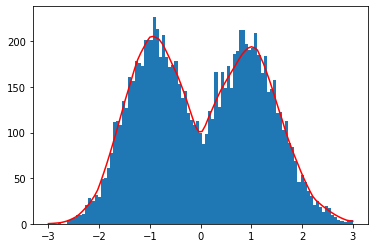

In [16]:
N = 10000

x_lin = torch.linspace(-3, 3, 100).reshape(100,-1)
dx = x_lin[1] - x_lin[0]

psi = model.forward_DNN(x_lin)[:,0].detach().numpy()

x = model.sample(N, 20)[0].detach().numpy()

bins = np.linspace(-3, 3, 100)
plt.hist(x, bins=bins)
plt.plot(x_lin[:,0], N*psi**2/np.sum(psi**2), "r")
plt.show()

## Estimating energy

In [20]:
N = 100000

model.resetHidden(N) 
x1 = model.sample(N, n)[0].detach() #sample N positions for first particle
psi1 = model.forward_DNN(x1)

model.forward_RNN(x1)               #Advance hidden state based on previous sampled positions
x2 = model.sample(N, n)[0].detach() #Sample positions for second particle, corrolated with first particle
psi2 = model.forward_DNN(x2)        

psi_total = psi1*psi2               #Total wave function

#Numerical laplacian
model.resetHidden(N)
psi1_plus = model.forward_DNN(x1+h) #Change particle 1 coordinate, holding particle 2 constant. 
model.forward_RNN(x1 + h)           #however, psi2 still changes because of corrolation
psi2_plus = model.forward_DNN(x2)

model.resetHidden(N)
psi1_minus = model.forward_DNN(x1-h)
model.forward_RNN(x1 - h)
psi2_minus = model.forward_DNN(x2)

lap1 = 1/psi_total*(psi1_plus*psi2_plus - 2*psi_total + psi1_minus*psi2_minus)/h**2

model.resetHidden(N)
model.forward_RNN(x1)
psi2_plus = model.forward_DNN(x2+h) #Change particle 2 coordinate, holding particle 1 constant.
psi2_minus = model.forward_DNN(x2-h)

lap2 = 1/psi2*(psi2_plus - 2*psi2 + psi2_minus)/h**2    #psi1 factor here, since it is constant


E = (-0.5*(lap1 + lap2) + 0.5*(x1**2 + x2**2) + 1/torch.sqrt((x1 - x2)**2 + 0.1**2))
E = torch.mean(E)
print(E.item())

2.59435772895813
